In [1]:
import os
from polynomialfeatures import rsmprofiler as rsm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
def grid_plotter(dfX, dfY, group = None, plot_title = None, y_label = 'Response', x_scale = 'linear', y_scale = 'linear', share_y = True, share_x = False,figsize = None):
    
    nrows = 1
    cols = dfX.columns
    ncols = len(cols)
    if figsize is None:
        figsize = [4*ncols,4*nrows]
    
    fig, axs = plt.subplots(nrows,ncols, sharex = share_x, sharey = share_y, figsize = figsize)
    #fig.tight_layout()
    
    for idx,cl in enumerate(cols):
        X = dfX[cl]
        Y = dfY[cl]
        
        if idx == 0:
            legend = 'brief'
        else:
            legend = False
        
        sns.lineplot(x = X, y = Y, ax = axs[idx], style = group, hue = group, markers = False, legend = legend)
        
        #axs[idx,jdx].set_title('{}={}, {}={}'.format(row,rw,col,cl))
        axs[idx].set_xscale(x_scale)
        axs[idx].set_yscale(y_scale)
        
        axs[idx].set_ylabel(y_label)  
        
    fig.subplots_adjust(wspace=0.15, hspace=0.25)
    plt.suptitle(plot_title)
    return fig

## Single regression model using RSMProfiler

Load csv file with regression coefficients. Note only "Term" and "Estimate" columns are required.

In [3]:
df = pd.read_csv(os.path.join(os.getcwd(),'estimates/coeff_A.csv'))
df.head()

Term   Estimate  Std Error  t Ratio Prob>|t|
0  Intercept  71.679747   1.674168    42.82   <.0001
1        SCF   9.913870   1.857172     5.34   <.0001
2       IL-3  15.841512   1.857172     8.53   <.0001
3       TNFa  32.033221   1.857172    17.25   <.0001
4   SCF*TNFa   7.191631   2.157839     3.33   0.0017

Create a `RSMProfiler` object. Factor name spelling must match what is in the coefficients csv. The `RSMProfiler` can hold more factors than provided in the csv, and their value will be set to 0. 

In [4]:
# Factor names
factors = ['SCF','Flt3L','IL-3','IL-7','TNFa','CXCL12']
# Create profiler
profiler = rsm.RSMProfiler(factors = factors,
                           params = df,
                           factor_base = 2,
                           factor_constant = [1,1,1,1,1,1]
                          )
# Fit the regression model
profiler.fit()

Sweep one factor at a time while holding the other values constant. Simply intended for plotting.

In [6]:
X,Y = profiler.sweep(factor_range = [-1,1],inverse_scale_factors=True)

In [7]:
Y.head()

SCF      Flt3L       IL-3       IL-7       TNFa     CXCL12
0  61.765877  71.679747  55.838235  71.679747  39.646526  71.679747
1  61.966157  71.679747  56.158265  71.679747  40.293662  71.679747
2  62.166437  71.679747  56.478296  71.679747  40.940798  71.679747
3  62.366717  71.679747  56.798326  71.679747  41.587933  71.679747
4  62.566998  71.679747  57.118357  71.679747  42.235069  71.679747

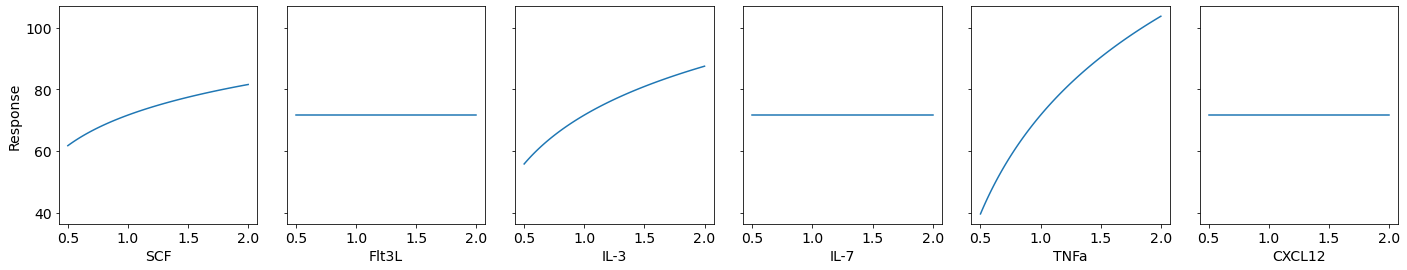

In [8]:
fig = grid_plotter(X,Y, y_scale = 'linear', x_scale = 'linear', share_y = True)

## Multiple regression models using MultiRSM
This is used similarly to the single model using RSMProfiler. It performs all the same functions but for all models.

In [28]:
param_fp = [os.path.join(os.getcwd(),'estimates/coeff_A.csv'),
            os.path.join(os.getcwd(),'estimates/coeff_B.csv'),
           ]

In [29]:
multiprofiler = rsm.MultiRSM(factors = factors,
                             params = param_fp,
                             factor_base = 2,
                             factor_constant = [1,1,1,1,1,1],
                             names = ['A','B']
                             )

In [30]:
# Sweep low to high
X,Y = multiprofiler.sweep(factor_range = [-2.366,2.366],inverse_scale_factors=True)

In [35]:
# Normalize for plotting
Y = Y/Y.max()

In [40]:
# To prevent index error in seaborn
grps = Y.index.tolist()
Y = Y.reset_index(drop=True)
X = X.reset_index(drop=True)

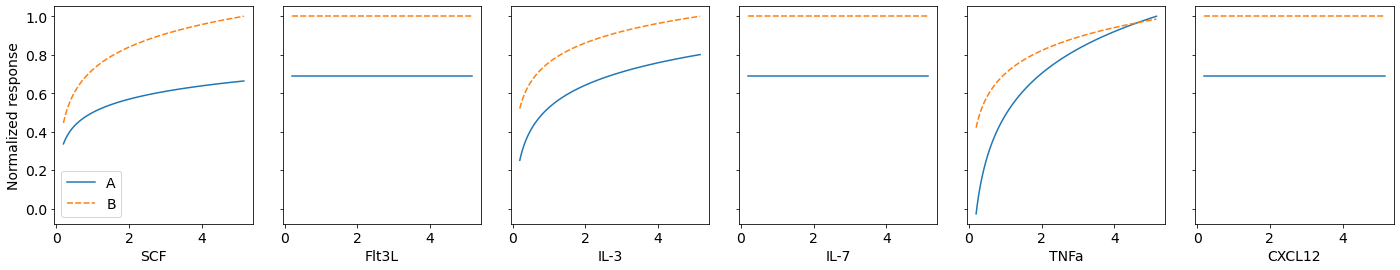

In [42]:
fig = grid_plotter(X,Y, group = grps, y_scale = 'linear', x_scale = 'linear', share_y = True, y_label = 'Normalized response')